In [1]:
# Test of the threading

In [1]:
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity, ControlSettingName

In [2]:
# Make Controller - this automatically starts the thread
Controller = get_control_module(sim_mode=True)

In [3]:
Controller.start()


#Record a minute of activity
ls = []
tt = []

for t in np.arange(0, 60,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        Controller.heartbeat()
    
    if t>15:    #after 15 sec, set PEEP to 10 and PIP to 16
        command = ControlSetting(name=ControlSettingName.PEEP, value=10, min_value=9, max_value=12, timestamp=time.time())
        Controller.set_control(command)
        command = ControlSetting(name=ControlSettingName.PIP, value=16, min_value=15, max_value=17, timestamp=time.time())
        Controller.set_control(command)
        command = ControlSetting(name=ControlSettingName.INSPIRATION_TIME_SEC, value=1.8, min_value=1.3, max_value=2.0, timestamp=time.time())
        Controller.set_control(command)
        
    if t>35:    #after 35 sec, set PEEP to 7, PIP to 20, and bpm to 10
        command = ControlSetting(name=ControlSettingName.PEEP, value=7, min_value=5, max_value=9, timestamp=time.time())
        Controller.set_control(command)
        command = ControlSetting(name=ControlSettingName.PIP, value=20, min_value=18, max_value=22, timestamp=time.time())
        Controller.set_control(command)
        command = ControlSetting(name=ControlSettingName.BREATHS_PER_MINUTE, value=10, min_value=8, max_value=11, timestamp=time.time()) 
        Controller.set_control(command)
        
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time())
    
    time.sleep(0.05)

Controller running...
Current loop = 0.

Controller running...
Current loop = 452.

Controller running...
Current loop = 900.

Controller running...
Current loop = 1352.

Controller running...
Current loop = 1799.

Controller running...
Current loop = 2249.

Controller running...
Current loop = 2697.

Controller running...
Current loop = 3138.

Controller running...
Current loop = 3594.

Controller running...
Current loop = 4056.

Controller running...
Current loop = 4510.

Controller running...
Current loop = 4979.



In [6]:
Controller.stop()
Controller.heartbeat()

Main Loop is not running.
Controller not running...
Current loop = 14527.



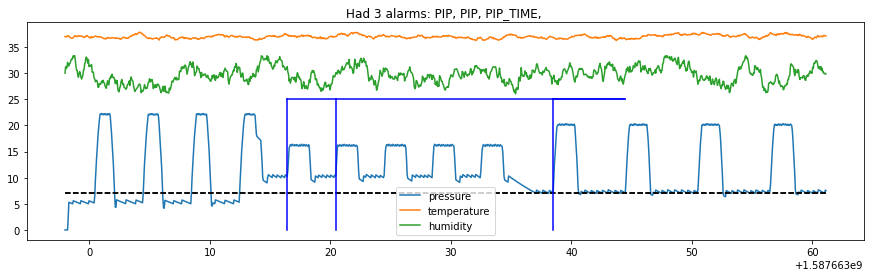

In [14]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ControlSettingName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ControlSettingName.PEEP)
pip = cc.value

pl.plot(tt, [s.pressure for s in ls], label = 'pressure')
pl.plot(tt, [s.temp for s in ls], label = "temperature")
pl.plot(tt, [s.humidity/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

active_alarms = Controller.get_active_alarms()
logged_alarms = Controller.get_logged_alarms()

for active_alarm_key in active_alarms.keys():
    alarm = active_alarms[active_alarm_key]
    pl.plot([alarm.alarm_start_time, alarm.alarm_start_time], [0,25], 'r-')
    
for alarm in logged_alarms:
    pl.plot([alarm.alarm_start_time, alarm.alarm_start_time], [0,25], 'b-')
    pl.plot([alarm.alarm_start_time, alarm.alarm_end_time],  [25,25], 'b-')

s = "Had " + str(len(Controller.get_alarms())) + " alarms: "
for alarm in Controller.get_alarms():
    s = s + alarm.alarm_name + ", "
    
pl.title(s)
pl.legend()